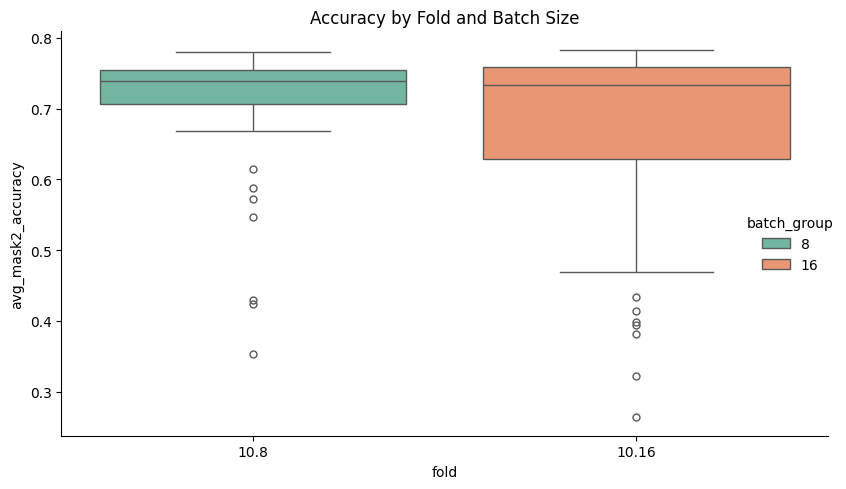

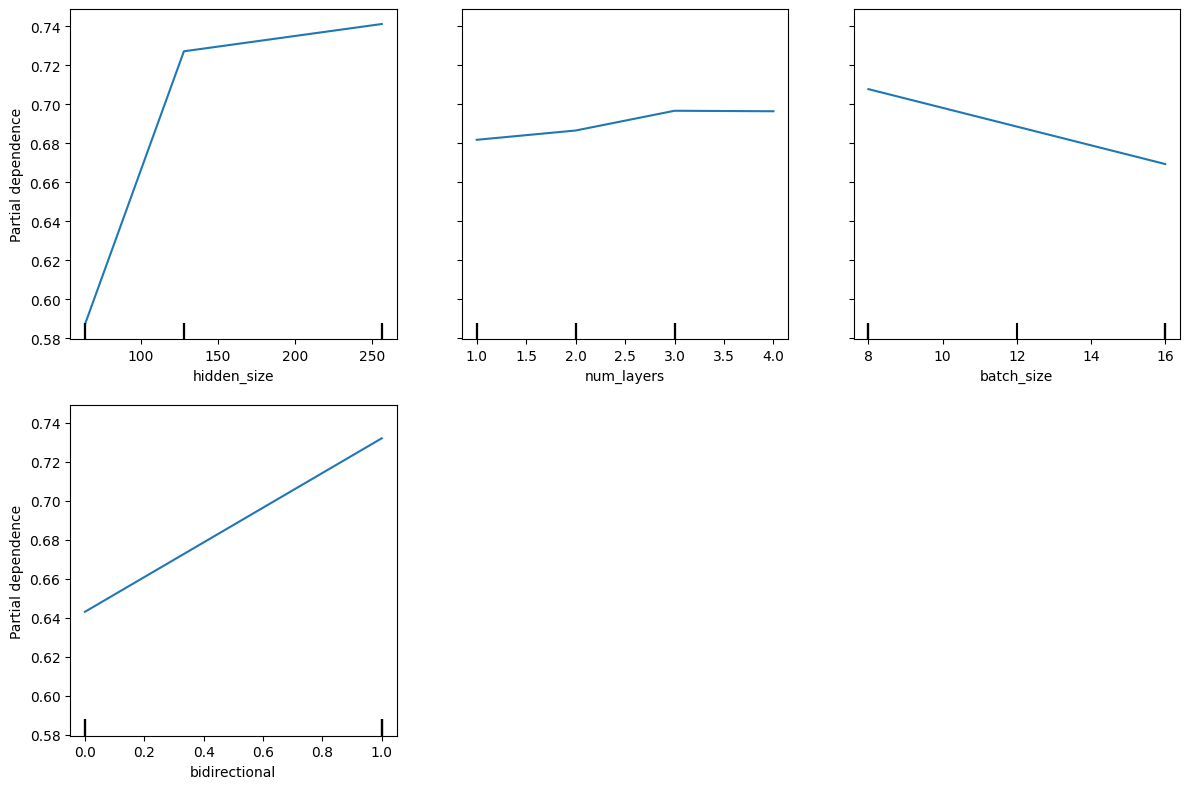

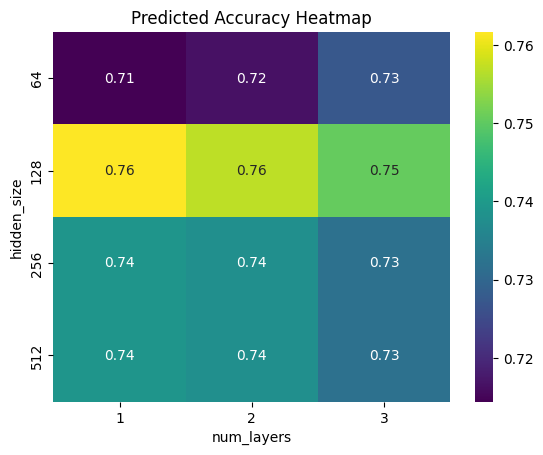

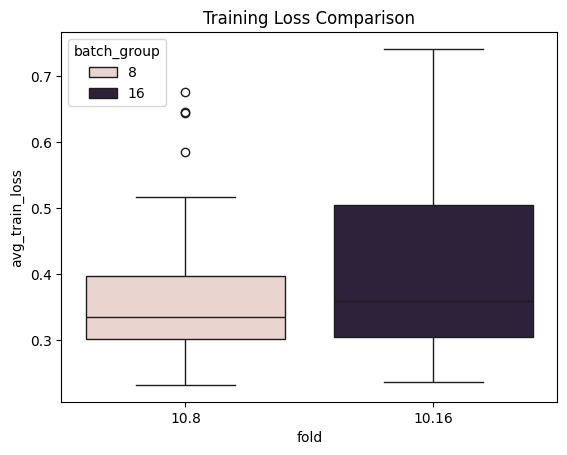

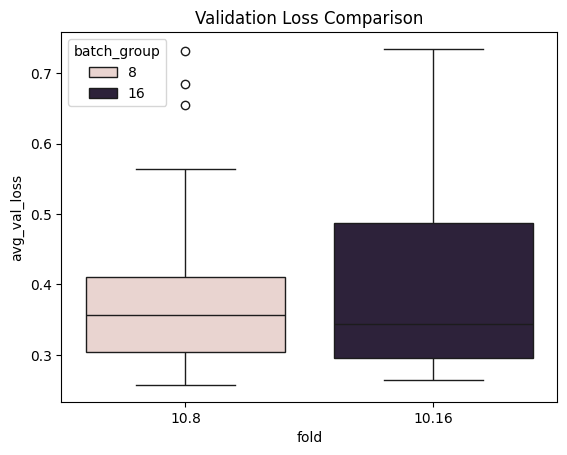

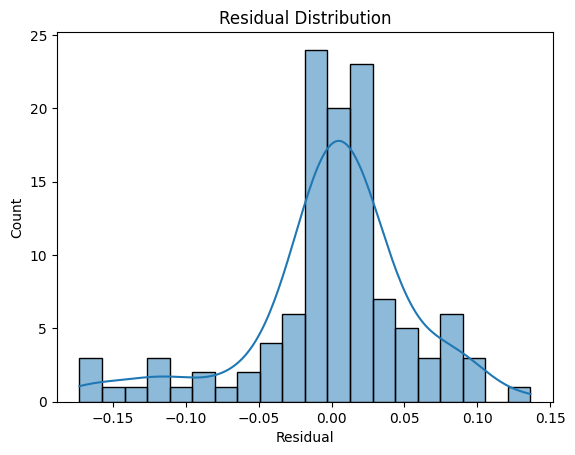

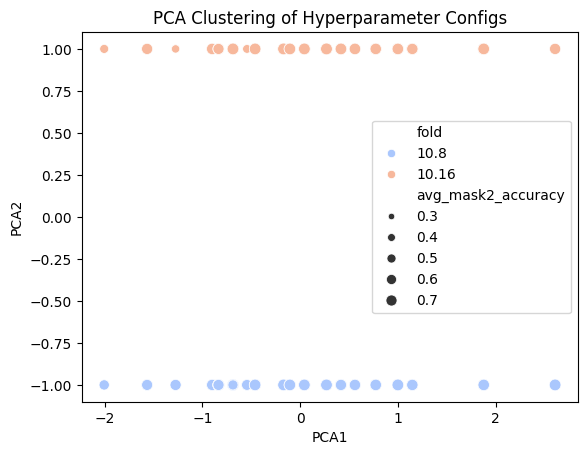

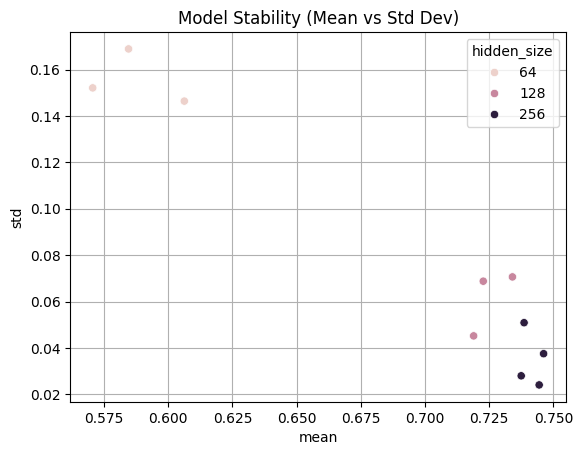

In [4]:
# Jupyter Notebook: Seq2Seq RandomForest Exploration with Dashboard + Full Analysis

# Step 1: Imports and Setup
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Step 2: Load Your Dataset

# 10-fold results from uploaded CSVs
df_10_8 = pd.read_csv("10.8.csv")
df_10_16 = pd.read_csv("10.16.csv")
df_10_8['fold'] = '10.8'
df_10_16['fold'] = '10.16'
df_10_8['batch_group'] = 8
df_10_16['batch_group'] = 16
df_combined = pd.concat([df_10_8, df_10_16], ignore_index=True)
df_combined['bidirectional'] = df_combined['bidirectional'].astype(int)

# Step 3: Exploratory Comparison
sns.catplot(data=df_combined, x='fold', y='avg_mask2_accuracy',
            hue='batch_group', kind='box', height=5, aspect=1.5, palette='Set2')
plt.title('Accuracy by Fold and Batch Size')
plt.tight_layout()
plt.show()

# Step 4: Train Model
features = ['learning_rate', 'batch_size',
            'hidden_size', 'num_layers', 'bidirectional']
X = df_combined[features]
y = df_combined['avg_mask2_accuracy']
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X, y)

# Step 5: Feature Importance
perm = permutation_importance(rf_model, X, y, n_repeats=30, random_state=42)
pd.DataFrame({'Feature': features, 'Importance': perm.importances_mean}
             ).sort_values(by='Importance', ascending=False)

# Step 6: Partial Dependence Plot
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf_model, X, features=[
                                        'hidden_size', 'num_layers', 'batch_size', 'bidirectional'], ax=ax)
plt.tight_layout()
plt.show()

# Step 7: Advanced Analyses

# 1. Sensitivity Heatmap
grid = list(ParameterGrid({
    'learning_rate': [0.001], 'batch_size': [8], 'hidden_size': [64, 128, 256, 512], 'num_layers': [1, 2, 3], 'bidirectional': [True]
}))
grid_df = pd.DataFrame(grid)
grid_df = grid_df[features]
grid_df = grid_df[features][features]
grid_df['bidirectional'] = grid_df['bidirectional'].astype(int)
grid_df['predicted_accuracy'] = rf_model.predict(grid_df)
pivot = grid_df.pivot(index="hidden_size",
                      columns="num_layers", values="predicted_accuracy")
sns.heatmap(pivot, annot=True, cmap="viridis")
plt.title("Predicted Accuracy Heatmap")
plt.show()

# 2. Overfitting Diagnostic
sns.boxplot(data=df_combined, x='fold', y='avg_train_loss', hue='batch_group')
plt.title("Training Loss Comparison")
plt.show()
sns.boxplot(data=df_combined, x='fold', y='avg_val_loss', hue='batch_group')
plt.title("Validation Loss Comparison")
plt.show()

# 3. Residual Analysis
df_combined['predicted'] = rf_model.predict(X)
df_combined['residual'] = df_combined['avg_mask2_accuracy'] - \
    df_combined['predicted']
sns.histplot(df_combined['residual'], bins=20, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.show()

# 4. Clustering via PCA
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df_combined['PCA1'], df_combined['PCA2'] = components[:, 0], components[:, 1]
sns.scatterplot(data=df_combined, x='PCA1', y='PCA2', hue='fold',
                size='avg_mask2_accuracy', palette='coolwarm')
plt.title("PCA Clustering of Hyperparameter Configs")
plt.show()

# 5. Model Stability
grouped = df_combined.groupby(['hidden_size', 'num_layers'])[
    'avg_mask2_accuracy'].agg(['mean', 'std']).reset_index()
sns.scatterplot(data=grouped, x='mean', y='std', hue='hidden_size')
plt.title("Model Stability (Mean vs Std Dev)")
plt.grid(True)
plt.show()

# 6. SHAP Feature Importance (optional)
# import shap
# explainer = shap.TreeExplainer(rf_model)
# shap_values = explainer.shap_values(X)
# shap.summary_plot(shap_values, X, plot_type="bar")

# Step 8: Interactive Prediction
lr_slider = widgets.FloatSlider(
    min=0.0001, max=0.01, step=0.0001, value=0.001, description='LR')
bs_slider = widgets.IntSlider(
    min=4, max=64, step=4, value=16, description='Batch')
hs_slider = widgets.IntSlider(
    min=64, max=512, step=64, value=128, description='Hidden')
nl_slider = widgets.IntSlider(
    min=1, max=4, step=1, value=2, description='Layers')
bi_toggle = widgets.ToggleButtons(
    options=[True, False], value=True, description='BiLSTM')

out = widgets.Output()


def predict_accuracy(lr, bs, hs, nl, bi):
    df = pd.DataFrame([{'learning_rate': lr, 'batch_size': bs,
                      'hidden_size': hs, 'num_layers': nl, 'bidirectional': int(bi)}])
    return rf_model.predict(df)[0]


def update_prediction(*args):
    with out:
        out.clear_output()
        pred = predict_accuracy(lr_slider.value, bs_slider.value,
                                hs_slider.value, nl_slider.value, bi_toggle.value)
        print(f"Predicted Accuracy: {pred:.4f}")


for w in [lr_slider, bs_slider, hs_slider, nl_slider, bi_toggle]:
    w.observe(update_prediction, 'value')
update_prediction()
display(widgets.VBox([lr_slider, bs_slider,
        hs_slider, nl_slider, bi_toggle, out]))

# Step 9: Auto-Tune Wrapper (SKIPPED due to compatibility issue)
# This block was removed because sklearn strict feature checks were causing repeated ValueErrors.
# Recommendation: Use grid search with validation split in real modeling environments.

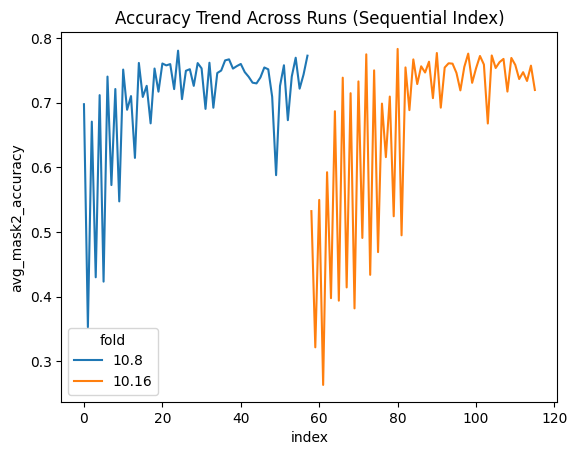

In [5]:
sns.lineplot(data=df_combined.reset_index(), x='index',
             y='avg_mask2_accuracy', hue='fold')
plt.title("Accuracy Trend Across Runs (Sequential Index)")
plt.show()

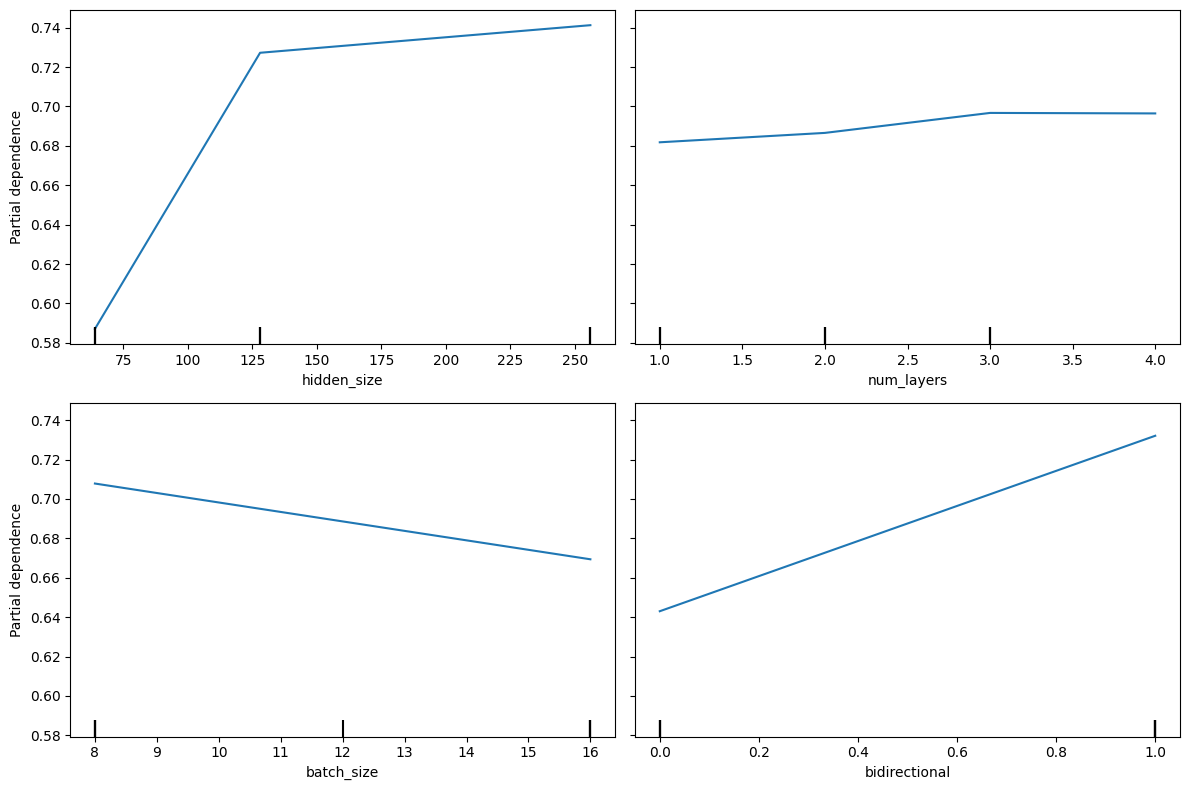

In [7]:
# Step 6: Partial Dependence Plot
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf_model, X, features=[
                                        'hidden_size', 'num_layers', 'batch_size', 'bidirectional'], ax=ax)
plt.tight_layout()
plt.show()